In [1]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
import tensorflow as tf
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import xarray
import haiku as hk
import jax 
from jax import numpy as jnp
from jax import value_and_grad
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import tensorflow_probability as tfp
from tensorflow.keras import layers
import sklearn

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
cd /Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data

/Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data


## Data Preprocessing

In [3]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks={'n': 1})
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y_obs.values-Y_shift)/np.sqrt(Y_scalar)
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [4]:
area_weight=dataset.area[0]

In [5]:
area_weight_arr=area_weight.mean(dim="lon").values

In [6]:
area_weight_arr/=sum(area_weight_arr)

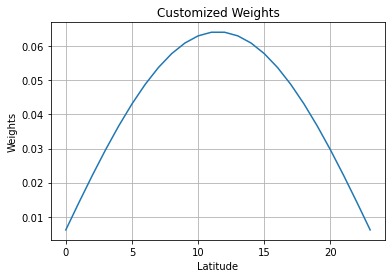

In [7]:
plt.plot(area_weight_arr)
plt.title("Customized Weights")
plt.xlabel("Latitude")
plt.ylabel("Weights")
plt.grid()

In [8]:
X=X_s.copy()
Y_obs=Y_np.copy()
Y_shifted=Y.values.mean()
Y_std=Y.values.std()
Y=(Y.values-Y.values.mean())/(Y.values.std())
# Y=np.array([Yi.flatten() for Yi in Y])

In [9]:
Y=Y.reshape(250,24,48)

## Train, Test Split

In [10]:
index=np.random.choice(250,50)
X_test=X[index]
Y_test=Y[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X[Index_x_bool]
Y_train=Y[Index_x_bool]

## Model

In [11]:
BaseEstimator=sklearn.base.BaseEstimator

In [12]:
bandwidth=2
shift=1e-3

244.69193226422033


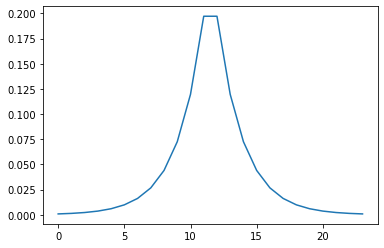

In [13]:
z=np.exp(-np.abs(np.arange(24,dtype=float)-11.5)/bandwidth+shift)
weights=z/np.sum(z)
print(z[11]/z[-1])
plt.plot(weights)

In [14]:
class DeConvNeuralNetwork(BaseEstimator):
    def __init__(self,learning_rate=1e-4,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.model=None
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred
        z=kb.exp(-kb.abs(kb.arange(24,dtype=float)-11.5)/2+1e-15)
        weights=z/kb.sum(z)
        custom_loss=kb.mean(err**2* kb.reshape(weights,(1,-1,1)))**0.5
        #custom_loss=kb.square(y_actual-y_pred)
        return custom_loss
    def fit(self,X,y,X_test,Y_test):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=5))
        model.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Reshape((3,3,1)))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3), strides=(1, 1), padding='same'))
        lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=1000,decay_rate=0.7)
        model.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=self.custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        history=model.fit(X,y,epochs=self.epochs,validation_data=(X_test,Y_test))
        self.history=history
        self.model=model
        return model,history
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)
    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
    def evaluate(self,X,Y):
        return self.model.evaluate(X,Y)
    def plot_model(self,to_file='large_model_plot.png', show_shapes=True, show_layer_names=False):
        plot_model(self.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [20]:
DNN=DeConvNeuralNetwork(epochs=2000)

In [21]:
model2,history2=DNN.fit(X_train,Y_train,X_test,Y_test)

Epoch 1/2000
7/7 [==============================] - 2s 108ms/step - loss: 0.1401 - root_mean_squared_error: 1.0413 - val_loss: 0.1336 - val_root_mean_squared_error: 1.0030
Epoch 2/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.1255 - root_mean_squared_error: 0.9934 - val_loss: 0.1337 - val_root_mean_squared_error: 1.0030
Epoch 3/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.1187 - root_mean_squared_error: 0.9800 - val_loss: 0.1337 - val_root_mean_squared_error: 1.0031
Epoch 4/2000
7/7 [==============================] - 0s 28ms/step - loss: 0.1112 - root_mean_squared_error: 0.9676 - val_loss: 0.1337 - val_root_mean_squared_error: 1.0029
Epoch 5/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.1025 - root_mean_squared_error: 0.9439 - val_loss: 0.1337 - val_root_mean_squared_error: 1.0031
Epoch 6/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0940 - root_mean_squared_error: 0.9053 - val_loss: 0.1340 - val_root_

Epoch 49/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0326 - root_mean_squared_error: 0.2743 - val_loss: 0.0502 - val_root_mean_squared_error: 0.3346
Epoch 50/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0320 - root_mean_squared_error: 0.2728 - val_loss: 0.0505 - val_root_mean_squared_error: 0.3342
Epoch 51/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0316 - root_mean_squared_error: 0.2697 - val_loss: 0.0486 - val_root_mean_squared_error: 0.3245
Epoch 52/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0311 - root_mean_squared_error: 0.2652 - val_loss: 0.0467 - val_root_mean_squared_error: 0.3123
Epoch 53/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0320 - root_mean_squared_error: 0.2637 - val_loss: 0.0456 - val_root_mean_squared_error: 0.3095
Epoch 54/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0334 - root_mean_squared_error: 0.2634 - val_loss: 0.0480 - val_

7/7 [==============================] - 0s 22ms/step - loss: 0.0245 - root_mean_squared_error: 0.1890 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1954
Epoch 144/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0232 - root_mean_squared_error: 0.1875 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1935
Epoch 145/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0241 - root_mean_squared_error: 0.1877 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1910
Epoch 146/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0240 - root_mean_squared_error: 0.1876 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1901
Epoch 147/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0242 - root_mean_squared_error: 0.1866 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1918
Epoch 148/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0226 - root_mean_squared_error: 0.1851 - val_loss: 0.0244 - val_root_mean

7/7 [==============================] - 0s 22ms/step - loss: 0.0201 - root_mean_squared_error: 0.1618 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1665
Epoch 238/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0201 - root_mean_squared_error: 0.1612 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1647
Epoch 239/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0211 - root_mean_squared_error: 0.1626 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1660
Epoch 240/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0203 - root_mean_squared_error: 0.1617 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1669
Epoch 241/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0207 - root_mean_squared_error: 0.1614 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1653
Epoch 242/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0205 - root_mean_squared_error: 0.1618 - val_loss: 0.0230 - val_root_mean

7/7 [==============================] - 0s 22ms/step - loss: 0.0196 - root_mean_squared_error: 0.1502 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1557
Epoch 332/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0185 - root_mean_squared_error: 0.1497 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1519
Epoch 333/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0182 - root_mean_squared_error: 0.1486 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1524
Epoch 334/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0186 - root_mean_squared_error: 0.1493 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1521
Epoch 335/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0184 - root_mean_squared_error: 0.1490 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1528
Epoch 336/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0207 - root_mean_squared_error: 0.1512 - val_loss: 0.0245 - val_root_mean

7/7 [==============================] - 0s 22ms/step - loss: 0.0174 - root_mean_squared_error: 0.1411 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1449
Epoch 426/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0170 - root_mean_squared_error: 0.1403 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1473
Epoch 427/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0180 - root_mean_squared_error: 0.1412 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1464
Epoch 428/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0178 - root_mean_squared_error: 0.1419 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1454
Epoch 429/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0176 - root_mean_squared_error: 0.1404 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1453
Epoch 430/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0180 - root_mean_squared_error: 0.1414 - val_loss: 0.0211 - val_root_mean

7/7 [==============================] - 0s 22ms/step - loss: 0.0167 - root_mean_squared_error: 0.1360 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1402
Epoch 520/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0171 - root_mean_squared_error: 0.1364 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1411
Epoch 521/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0167 - root_mean_squared_error: 0.1365 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1406
Epoch 522/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0165 - root_mean_squared_error: 0.1354 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1400
Epoch 523/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0165 - root_mean_squared_error: 0.1366 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1397
Epoch 524/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0169 - root_mean_squared_error: 0.1359 - val_loss: 0.0221 - val_root_mean

7/7 [==============================] - 0s 22ms/step - loss: 0.0162 - root_mean_squared_error: 0.1325 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1389
Epoch 614/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0159 - root_mean_squared_error: 0.1320 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1375
Epoch 615/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0160 - root_mean_squared_error: 0.1322 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1381
Epoch 616/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0163 - root_mean_squared_error: 0.1328 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1379
Epoch 617/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0160 - root_mean_squared_error: 0.1323 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1371
Epoch 618/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0161 - root_mean_squared_error: 0.1323 - val_loss: 0.0219 - val_root_mean

7/7 [==============================] - 0s 23ms/step - loss: 0.0152 - root_mean_squared_error: 0.1289 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1356
Epoch 708/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0159 - root_mean_squared_error: 0.1304 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1349
Epoch 709/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0160 - root_mean_squared_error: 0.1301 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1364
Epoch 710/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0157 - root_mean_squared_error: 0.1295 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1366
Epoch 711/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0152 - root_mean_squared_error: 0.1290 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1348
Epoch 712/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0160 - root_mean_squared_error: 0.1300 - val_loss: 0.0220 - val_root_mean

7/7 [==============================] - 0s 22ms/step - loss: 0.0154 - root_mean_squared_error: 0.1276 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1336
Epoch 802/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0151 - root_mean_squared_error: 0.1273 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1331
Epoch 803/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0149 - root_mean_squared_error: 0.1270 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1330
Epoch 804/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0150 - root_mean_squared_error: 0.1268 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1332
Epoch 805/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0151 - root_mean_squared_error: 0.1272 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1331
Epoch 806/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0152 - root_mean_squared_error: 0.1274 - val_loss: 0.0202 - val_root_mean

7/7 [==============================] - 0s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.1254 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1323
Epoch 896/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0152 - root_mean_squared_error: 0.1258 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1323
Epoch 897/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0152 - root_mean_squared_error: 0.1257 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1319
Epoch 898/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0150 - root_mean_squared_error: 0.1258 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1325
Epoch 899/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.1259 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1323
Epoch 900/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - root_mean_squared_error: 0.1255 - val_loss: 0.0207 - val_root_mean

7/7 [==============================] - 0s 23ms/step - loss: 0.0145 - root_mean_squared_error: 0.1237 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1314
Epoch 990/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0146 - root_mean_squared_error: 0.1243 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1315
Epoch 991/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0157 - root_mean_squared_error: 0.1256 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1316
Epoch 992/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0146 - root_mean_squared_error: 0.1237 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1318
Epoch 993/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0146 - root_mean_squared_error: 0.1241 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1317
Epoch 994/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0145 - root_mean_squared_error: 0.1240 - val_loss: 0.0207 - val_root_mean

7/7 [==============================] - 0s 22ms/step - loss: 0.0146 - root_mean_squared_error: 0.1228 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1306
Epoch 1084/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0151 - root_mean_squared_error: 0.1238 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1301
Epoch 1085/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - root_mean_squared_error: 0.1238 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1316
Epoch 1086/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.1237 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1302
Epoch 1087/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0143 - root_mean_squared_error: 0.1227 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1306
Epoch 1088/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0142 - root_mean_squared_error: 0.1226 - val_loss: 0.0204 - val_root

7/7 [==============================] - 0s 22ms/step - loss: 0.0145 - root_mean_squared_error: 0.1224 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1304
Epoch 1178/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - root_mean_squared_error: 0.1228 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1302
Epoch 1179/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0142 - root_mean_squared_error: 0.1221 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1308
Epoch 1180/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0142 - root_mean_squared_error: 0.1221 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1299
Epoch 1181/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0142 - root_mean_squared_error: 0.1223 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1299
Epoch 1182/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0142 - root_mean_squared_error: 0.1223 - val_loss: 0.0204 - val_root

7/7 [==============================] - 0s 22ms/step - loss: 0.0142 - root_mean_squared_error: 0.1216 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1299
Epoch 1272/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - root_mean_squared_error: 0.1218 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1292
Epoch 1273/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0141 - root_mean_squared_error: 0.1219 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1293
Epoch 1274/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0140 - root_mean_squared_error: 0.1213 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1290
Epoch 1275/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0142 - root_mean_squared_error: 0.1219 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1292
Epoch 1276/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.1212 - val_loss: 0.0204 - val_root

7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.1210 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1284
Epoch 1366/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0142 - root_mean_squared_error: 0.1215 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1288
Epoch 1367/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.1208 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1287
Epoch 1368/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.1206 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1287
Epoch 1369/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.1210 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1286
Epoch 1370/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0143 - root_mean_squared_error: 0.1215 - val_loss: 0.0203 - val_root

7/7 [==============================] - 0s 21ms/step - loss: 0.0139 - root_mean_squared_error: 0.1208 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1284
Epoch 1460/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0140 - root_mean_squared_error: 0.1210 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1285
Epoch 1461/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.1205 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1286
Epoch 1462/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.1205 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1284
Epoch 1463/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0140 - root_mean_squared_error: 0.1210 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1284
Epoch 1464/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.1205 - val_loss: 0.0201 - val_root

7/7 [==============================] - 0s 22ms/step - loss: 0.0140 - root_mean_squared_error: 0.1207 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1280
Epoch 1554/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.1202 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1283
Epoch 1555/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0145 - root_mean_squared_error: 0.1214 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1287
Epoch 1556/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.1220 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1293
Epoch 1557/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0142 - root_mean_squared_error: 0.1209 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1289
Epoch 1558/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0143 - root_mean_squared_error: 0.1208 - val_loss: 0.0203 - val_root

7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.1200 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1279
Epoch 1648/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0137 - root_mean_squared_error: 0.1198 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1280
Epoch 1649/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0137 - root_mean_squared_error: 0.1198 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1280
Epoch 1650/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0137 - root_mean_squared_error: 0.1199 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1279
Epoch 1651/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0138 - root_mean_squared_error: 0.1200 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1280
Epoch 1652/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.1200 - val_loss: 0.0201 - val_root

7/7 [==============================] - 0s 23ms/step - loss: 0.0139 - root_mean_squared_error: 0.1199 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1282
Epoch 1742/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0138 - root_mean_squared_error: 0.1198 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1283
Epoch 1743/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0140 - root_mean_squared_error: 0.1203 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1283
Epoch 1744/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0138 - root_mean_squared_error: 0.1197 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1282
Epoch 1745/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0138 - root_mean_squared_error: 0.1199 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1282
Epoch 1746/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.1195 - val_loss: 0.0205 - val_root

7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.1195 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1279
Epoch 1836/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.1210 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1278
Epoch 1837/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.1195 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1281
Epoch 1838/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.1196 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1284
Epoch 1839/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0135 - root_mean_squared_error: 0.1193 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1280
Epoch 1840/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.1194 - val_loss: 0.0205 - val_root

7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.1193 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1277
Epoch 1930/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.1195 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1279
Epoch 1931/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.1193 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1279
Epoch 1932/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.1199 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1280
Epoch 1933/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.1192 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1279
Epoch 1934/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0140 - root_mean_squared_error: 0.1201 - val_loss: 0.0204 - val_root

In [22]:
DNN.evaluate(X_train,Y_train)

7/7 [==============================] - 0s 19ms/step - loss: 0.0132 - root_mean_squared_error: 0.1185


[0.013179750181734562, 0.11848275363445282]

In [23]:
DNN.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.0207 - root_mean_squared_error: 0.1280


[0.02067135088145733, 0.12802840769290924]

In [ ]:
Y_pred=DNN.predict(X_test)

In [ ]:
DNN.plot_loss()
plt.grid(True,which="minor")
plt.title("Exponential Loss Function")
plt.ylim(.01,0.2)
plt.xlabel("epochs")
plt.ylabel("Weighted MSE")

In [ ]:
loss=history2.history['loss']
val_loss=history2.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel("epochs")
plt.ylabel("error")
plt.legend(["train_loss","test_loss"])
plt.title("Test errors between train and test")

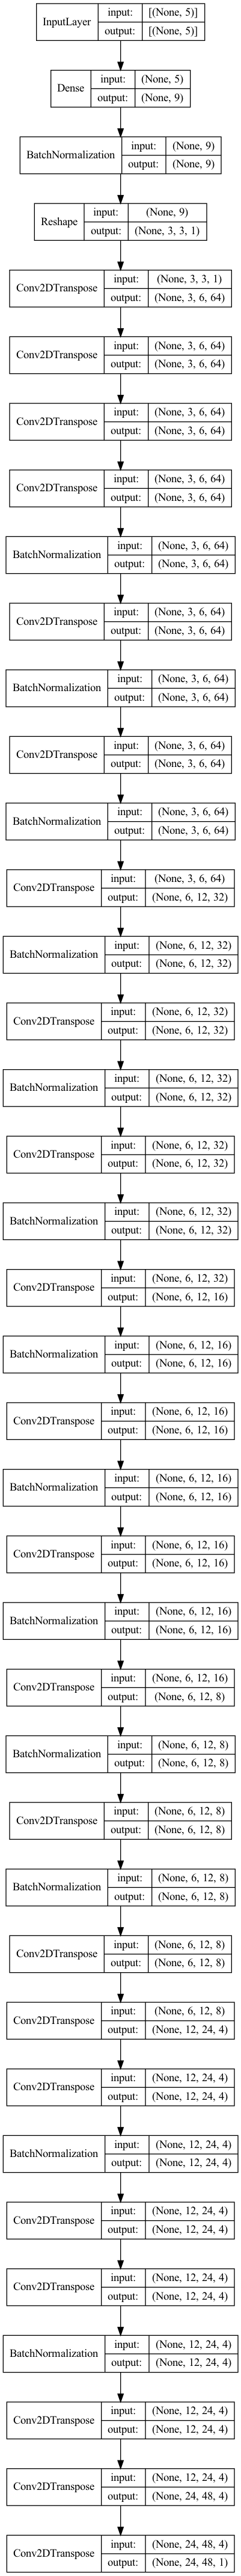

In [205]:
plot_model(DNN.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [206]:
DNN.model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 9)                 54        
                                                                 
 batch_normalization_170 (Ba  (None, 9)                36        
 tchNormalization)                                               
                                                                 
 reshape_10 (Reshape)        (None, 3, 3, 1)           0         
                                                                 
 conv2d_transpose_220 (Conv2  (None, 3, 6, 64)         1664      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_221 (Conv2  (None, 3, 6, 64)         102464    
 DTranspose)                                                     
                                                     

In [1]:
def plot(Y_pred,Y_test,i=0):
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    Y_plot=np.reshape(Y_pred[i],(24,48))
    y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_pred",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
        
    )
    sample_plot.show(y_pred_xr)
    Y_plot=np.reshape(Y_test[i],(24,48))
    y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_actual",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_obs_xr)
    sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
#     title="Y_pred-Y_test",
    rhs_title=r"$W/m^2$",
    lhs_title="",
        
    )
    diff = y_pred_xr-y_obs_xr
    diff[0,0] = 1
    diff[0,1] = -1
    sample_plot.show(diff)

In [2]:
plot(Y_pred,Y_test,-1)

NameError: name 'Y_pred' is not defined

In [209]:
mse_test=np.mean(np.square(Y_pred.squeeze()-Y_test))

In [210]:
mse_test2=np.sum(np.square(Y_pred.squeeze()-Y_test)*weights.reshape(1,-1,1))

In [211]:
mse_test2

17.366965077664695

In [212]:
mse_train=np.mean(np.square(DNN.predict(X_train).squeeze()-Y_train))

In [213]:
mse_test,mse_train

(0.012472336, 0.011692234)

In [216]:
np.sqrt(mse_test)

0.11167961

In [58]:
m_test2=np.sum(np.square(Y_test.mean(axis=0)-Y_test)*weights.reshape(1,-1,1))

In [59]:
m_test2

113.40840848091541

In [23]:
x_good=[-0.03182185, -0.37241268,  0.03075755, -0.33797872, 0.28431356]

## Map from Y to X

In [24]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1),activation='leaky_relu',input_shape=(24,48,1),padding='same'))
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(8*500,activation='leaky_relu'))
model2.add(tf.keras.layers.Dropout(.2))
model2.add(tf.keras.layers.Dense(1000,activation='leaky_relu'))
model2.add(tf.keras.layers.Dense(300,activation='leaky_relu'))
model2.add(tf.keras.layers.Dropout(.2))
model2.add(tf.keras.layers.Dense(100,activation='leaky_relu'))
# model2.add(tf.keras.layers.Dense(5))
model2.add(tf.keras.layers.Dense(5, activation='tanh'))



In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 48, 1)         26        
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 24, 64)        1664      
                                                                 
 batch_normalization_14 (Bat  (None, 12, 24, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 24, 64)        102464    
                                                                 
 batch_normalization_15 (Bat  (None, 12, 24, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 24, 64)       

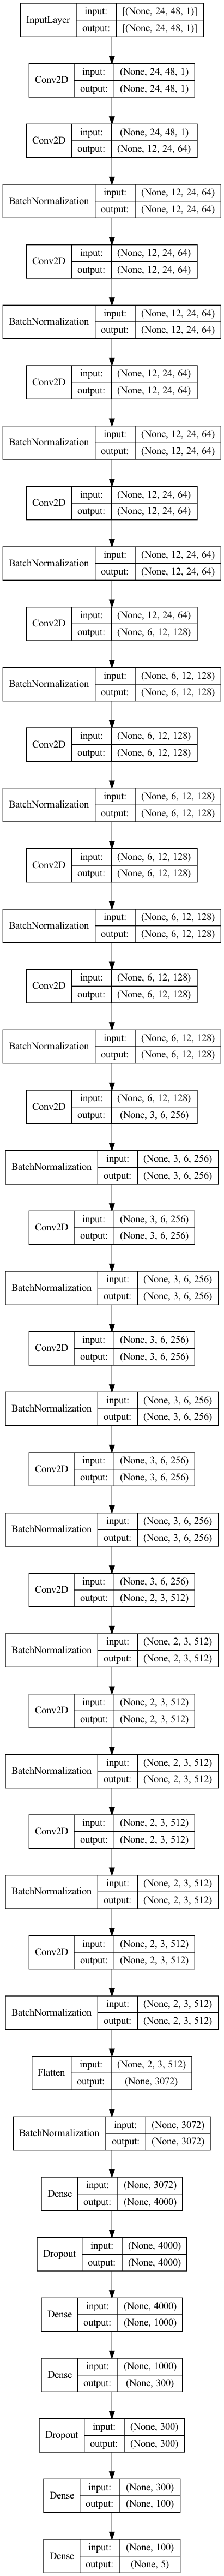

In [26]:
plot_model(model2, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [27]:
def custom_loss2(y_pred,y_actual):
    return kb.square(y_pred-y_actual)

In [28]:
lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4,decay_steps=1000,decay_rate=0.95)


In [29]:
model2.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=custom_loss2,
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [30]:
history=model2.fit(Y_train,X_train,epochs=1000)

Epoch 1/1000
7/7 [==============================] - 10s 748ms/step - loss: 1.1552 - root_mean_squared_error: 0.9015
Epoch 2/1000
7/7 [==============================] - 2s 233ms/step - loss: 1.2234 - root_mean_squared_error: 0.9457
Epoch 3/1000
7/7 [==============================] - 2s 340ms/step - loss: 1.2533 - root_mean_squared_error: 0.9670
Epoch 4/1000
7/7 [==============================] - 2s 321ms/step - loss: 1.1794 - root_mean_squared_error: 0.9317
Epoch 5/1000
7/7 [==============================] - 2s 272ms/step - loss: 1.0894 - root_mean_squared_error: 0.8841
Epoch 6/1000
7/7 [==============================] - 2s 300ms/step - loss: 1.0694 - root_mean_squared_error: 0.8735
Epoch 7/1000
7/7 [==============================] - 1s 190ms/step - loss: 1.1031 - root_mean_squared_error: 0.8928
Epoch 8/1000
7/7 [==============================] - 2s 330ms/step - loss: 1.0489 - root_mean_squared_error: 0.8619
Epoch 9/1000
7/7 [==============================] - 2s 234ms/step - loss: 0.977

7/7 [==============================] - 2s 263ms/step - loss: 0.4721 - root_mean_squared_error: 0.4834
Epoch 142/1000
7/7 [==============================] - 2s 286ms/step - loss: 0.6406 - root_mean_squared_error: 0.6348
Epoch 143/1000
7/7 [==============================] - 2s 345ms/step - loss: 0.6181 - root_mean_squared_error: 0.6171
Epoch 144/1000
7/7 [==============================] - 3s 364ms/step - loss: 0.7698 - root_mean_squared_error: 0.7294
Epoch 145/1000
7/7 [==============================] - 2s 259ms/step - loss: 0.7189 - root_mean_squared_error: 0.6921
Epoch 146/1000
7/7 [==============================] - 2s 296ms/step - loss: 0.6964 - root_mean_squared_error: 0.6743
Epoch 147/1000
7/7 [==============================] - 2s 320ms/step - loss: 0.7383 - root_mean_squared_error: 0.7034
Epoch 148/1000
7/7 [==============================] - 2s 303ms/step - loss: 0.6560 - root_mean_squared_error: 0.6415
Epoch 149/1000
7/7 [==============================] - 2s 305ms/step - loss: 0.5

7/7 [==============================] - 2s 276ms/step - loss: 0.5103 - root_mean_squared_error: 0.5383
Epoch 282/1000
7/7 [==============================] - 2s 288ms/step - loss: 0.4981 - root_mean_squared_error: 0.5275
Epoch 283/1000
7/7 [==============================] - 2s 319ms/step - loss: 0.5143 - root_mean_squared_error: 0.5434
Epoch 284/1000
7/7 [==============================] - 2s 309ms/step - loss: 0.5070 - root_mean_squared_error: 0.5375
Epoch 285/1000
7/7 [==============================] - 2s 237ms/step - loss: 0.4888 - root_mean_squared_error: 0.5212
Epoch 286/1000
7/7 [==============================] - 2s 292ms/step - loss: 0.4770 - root_mean_squared_error: 0.5107
Epoch 287/1000
7/7 [==============================] - 2s 311ms/step - loss: 0.4768 - root_mean_squared_error: 0.5114
Epoch 288/1000
7/7 [==============================] - 2s 292ms/step - loss: 0.4654 - root_mean_squared_error: 0.5012
Epoch 289/1000
7/7 [==============================] - 2s 247ms/step - loss: 0.4

7/7 [==============================] - 2s 282ms/step - loss: 0.3814 - root_mean_squared_error: 0.5014
Epoch 422/1000
7/7 [==============================] - 2s 306ms/step - loss: 0.3595 - root_mean_squared_error: 0.4796
Epoch 423/1000
7/7 [==============================] - 2s 310ms/step - loss: 0.3604 - root_mean_squared_error: 0.4811
Epoch 424/1000
7/7 [==============================] - 2s 293ms/step - loss: 0.3684 - root_mean_squared_error: 0.4900
Epoch 425/1000
7/7 [==============================] - 2s 316ms/step - loss: 0.3645 - root_mean_squared_error: 0.4865
Epoch 426/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.3686 - root_mean_squared_error: 0.4913
Epoch 427/1000
7/7 [==============================] - 2s 282ms/step - loss: 0.3664 - root_mean_squared_error: 0.4895
Epoch 428/1000
7/7 [==============================] - 2s 301ms/step - loss: 0.3733 - root_mean_squared_error: 0.4971
Epoch 429/1000
7/7 [==============================] - 2s 305ms/step - loss: 0.3

7/7 [==============================] - 2s 279ms/step - loss: 0.3203 - root_mean_squared_error: 0.4853
Epoch 562/1000
7/7 [==============================] - 2s 288ms/step - loss: 0.3208 - root_mean_squared_error: 0.4863
Epoch 563/1000
7/7 [==============================] - 2s 282ms/step - loss: 0.3336 - root_mean_squared_error: 0.4997
Epoch 564/1000
7/7 [==============================] - 2s 271ms/step - loss: 0.3184 - root_mean_squared_error: 0.4847
Epoch 565/1000
7/7 [==============================] - 2s 277ms/step - loss: 0.3130 - root_mean_squared_error: 0.4795
Epoch 566/1000
7/7 [==============================] - 2s 233ms/step - loss: 0.3184 - root_mean_squared_error: 0.4855
Epoch 567/1000
7/7 [==============================] - 2s 284ms/step - loss: 0.3338 - root_mean_squared_error: 0.5016
Epoch 568/1000
7/7 [==============================] - 2s 267ms/step - loss: 0.3096 - root_mean_squared_error: 0.4772
Epoch 569/1000
7/7 [==============================] - 2s 270ms/step - loss: 0.3

7/7 [==============================] - 2s 295ms/step - loss: 0.4251 - root_mean_squared_error: 0.5416
Epoch 702/1000
7/7 [==============================] - 2s 306ms/step - loss: 0.4229 - root_mean_squared_error: 0.5406
Epoch 703/1000
7/7 [==============================] - 2s 297ms/step - loss: 0.4135 - root_mean_squared_error: 0.5328
Epoch 704/1000
7/7 [==============================] - 2s 279ms/step - loss: 0.4122 - root_mean_squared_error: 0.5326
Epoch 705/1000
7/7 [==============================] - 2s 281ms/step - loss: 0.4208 - root_mean_squared_error: 0.5415
Epoch 706/1000
7/7 [==============================] - 2s 321ms/step - loss: 0.4233 - root_mean_squared_error: 0.5447
Epoch 707/1000
7/7 [==============================] - 2s 278ms/step - loss: 0.4265 - root_mean_squared_error: 0.5484
Epoch 708/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.4149 - root_mean_squared_error: 0.5384
Epoch 709/1000
7/7 [==============================] - 2s 296ms/step - loss: 0.4

7/7 [==============================] - 2s 241ms/step - loss: 0.3388 - root_mean_squared_error: 0.5009
Epoch 842/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.3494 - root_mean_squared_error: 0.5117
Epoch 843/1000
7/7 [==============================] - 2s 256ms/step - loss: 0.3469 - root_mean_squared_error: 0.5097
Epoch 844/1000
7/7 [==============================] - 2s 276ms/step - loss: 0.3427 - root_mean_squared_error: 0.5060
Epoch 845/1000
7/7 [==============================] - 2s 274ms/step - loss: 0.3195 - root_mean_squared_error: 0.4831
Epoch 846/1000
7/7 [==============================] - 2s 278ms/step - loss: 0.3222 - root_mean_squared_error: 0.4865
Epoch 847/1000
7/7 [==============================] - 2s 252ms/step - loss: 0.3194 - root_mean_squared_error: 0.4842
Epoch 848/1000
7/7 [==============================] - 2s 317ms/step - loss: 0.3105 - root_mean_squared_error: 0.4755
Epoch 849/1000
7/7 [==============================] - 2s 253ms/step - loss: 0.3

7/7 [==============================] - 2s 281ms/step - loss: 0.2983 - root_mean_squared_error: 0.4829
Epoch 982/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.4350 - root_mean_squared_error: 0.6085
Epoch 983/1000
7/7 [==============================] - 2s 317ms/step - loss: 0.6290 - root_mean_squared_error: 0.7505
Epoch 984/1000
7/7 [==============================] - 2s 244ms/step - loss: 0.5165 - root_mean_squared_error: 0.6683
Epoch 985/1000
7/7 [==============================] - 2s 300ms/step - loss: 0.4594 - root_mean_squared_error: 0.6205
Epoch 986/1000
7/7 [==============================] - 2s 274ms/step - loss: 0.4611 - root_mean_squared_error: 0.6198
Epoch 987/1000
7/7 [==============================] - 2s 264ms/step - loss: 0.4419 - root_mean_squared_error: 0.6033
Epoch 988/1000
7/7 [==============================] - 2s 283ms/step - loss: 0.4758 - root_mean_squared_error: 0.6306
Epoch 989/1000
7/7 [==============================] - 2s 297ms/step - loss: 0.4

/var/folders/yr/3yyj3s2j7ln9rr38ny17_0_m0000gn/T/ipykernel_22884/2581064636.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1.5)


Text(0, 0.5, 'MSE')

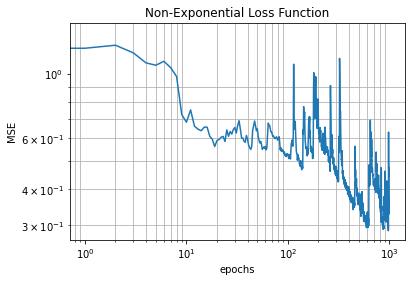

In [195]:

plt.loglog(history.history['loss'])
plt.grid(True,which="minor")
plt.title("Non-Exponential Loss Function")
plt.ylim(0,1.5)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [32]:
x_pred=model2.predict(Y_test)

In [33]:
x_pred

array([[ 8.52115750e-02,  9.91665483e-01,  7.41897881e-01,
         9.98288453e-01, -9.00636375e-01],
       [-1.48571849e-01, -1.02203138e-01, -8.51951689e-02,
         9.94250238e-01, -8.67416799e-01],
       [-9.50235873e-02,  5.39265215e-01,  2.12712556e-01,
         9.97938454e-01, -8.82702053e-01],
       [ 4.52941395e-02,  9.87985551e-01,  7.17644930e-01,
         9.99228358e-01, -9.10069704e-01],
       [ 1.66632747e-03,  9.90486503e-01,  7.50115395e-01,
         9.99856234e-01, -9.40134048e-01],
       [ 3.83532606e-02,  9.87411380e-01,  7.15083778e-01,
         9.99329746e-01, -9.12085116e-01],
       [ 2.55980920e-02,  9.89922404e-01,  7.39639103e-01,
         9.99684155e-01, -9.27441299e-01],
       [-5.97732700e-02,  8.80477548e-01,  4.60770309e-01,
         9.98464286e-01, -8.68439615e-01],
       [ 9.38876718e-02,  9.91303086e-01,  7.35512972e-01,
         9.97448981e-01, -8.92305911e-01],
       [ 4.70377393e-02,  9.82746959e-01,  6.79222167e-01,
         9.98521864e-01

In [34]:
x_pred.min(),x_pred.max()

(-0.9483439, 0.9998999)

In [35]:
model2.evaluate(Y_train,X_train)

7/7 [==============================] - 2s 79ms/step - loss: 0.9891 - root_mean_squared_error: 0.9581


[0.9890797734260559, 0.9580710530281067]

In [36]:
model2.evaluate(Y_test,X_test)

2/2 [==============================] - 1s 390ms/step - loss: 0.9441 - root_mean_squared_error: 0.9343


[0.9440904855728149, 0.9342970848083496]

In [37]:
Y_obs_re=Y_obs.reshape(1,24,48)

In [38]:
x_obs_a=model2.predict(Y_obs_re)

In [39]:
x_obs_a

array([[ 0.10368209,  0.99213374,  0.74069786,  0.99682766, -0.88985157]],
      dtype=float32)

In [75]:
feature_transform.inverse_transform(x_obs_a)

array([[ 9.29433095e+02,  4.98426747e+00,  4.48139572e-01,
         1.43800143e+04, -1.89535899e-03]])

In [40]:
Y_obs_pred=DNN.predict(x_obs_a)

In [41]:
np.min(np.array(model2.weights[-1]))

-0.027473068

[[ 0.47363523  0.6680532   0.82821816 ...  1.0611508   0.85573757
   0.7727188 ]
 [ 0.660396    0.75390965  1.0212097  ...  0.60841465  0.67681086
   0.3549436 ]
 [-0.09403144  0.04724661  0.1891121  ... -0.5775027  -0.64377636
  -0.3615337 ]
 ...
 [ 0.7786559   0.85684407  0.9310249  ...  0.9786637   1.115747
   0.863445  ]
 [ 0.71913123  0.9869235   1.1616538  ...  0.9274439   1.0115526
   0.8104305 ]
 [ 0.5255345   0.61858726  0.78186035 ...  0.77999055  0.78103304
   0.73748314]]


/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

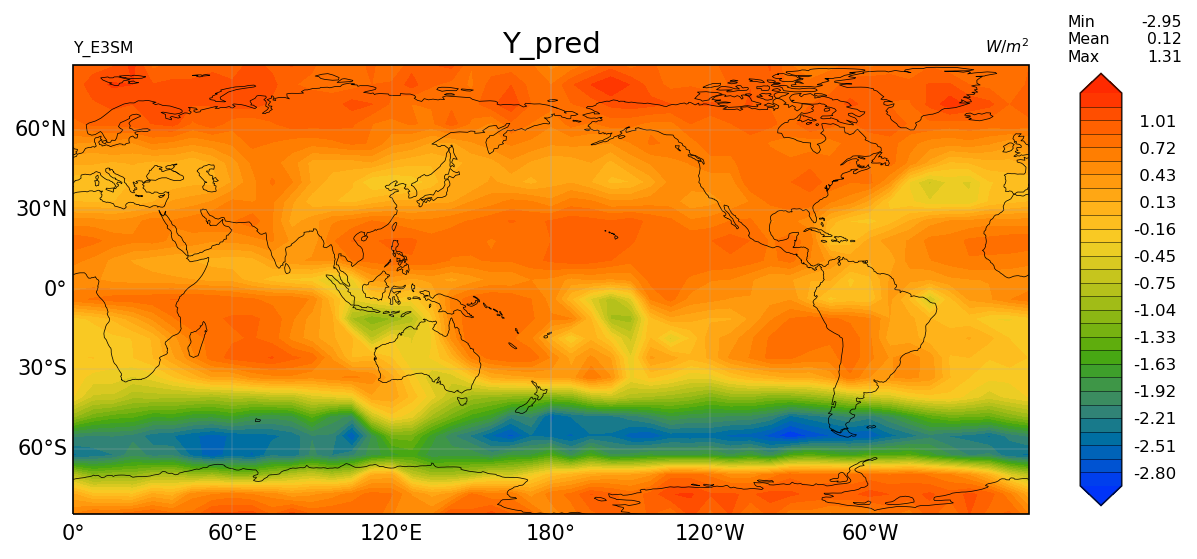

In [42]:
lat = dataset['lat'].values
lon = dataset['lon'].values
Y_plot=np.reshape(Y_obs_pred,(24,48))
print(Y_plot)
y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_pred",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_pred_xr)

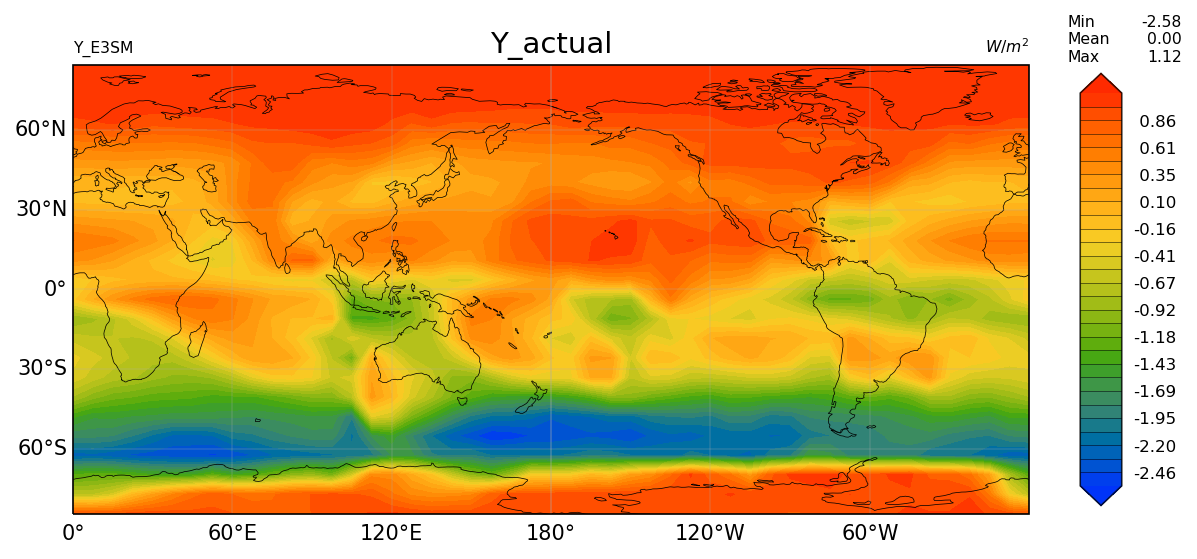

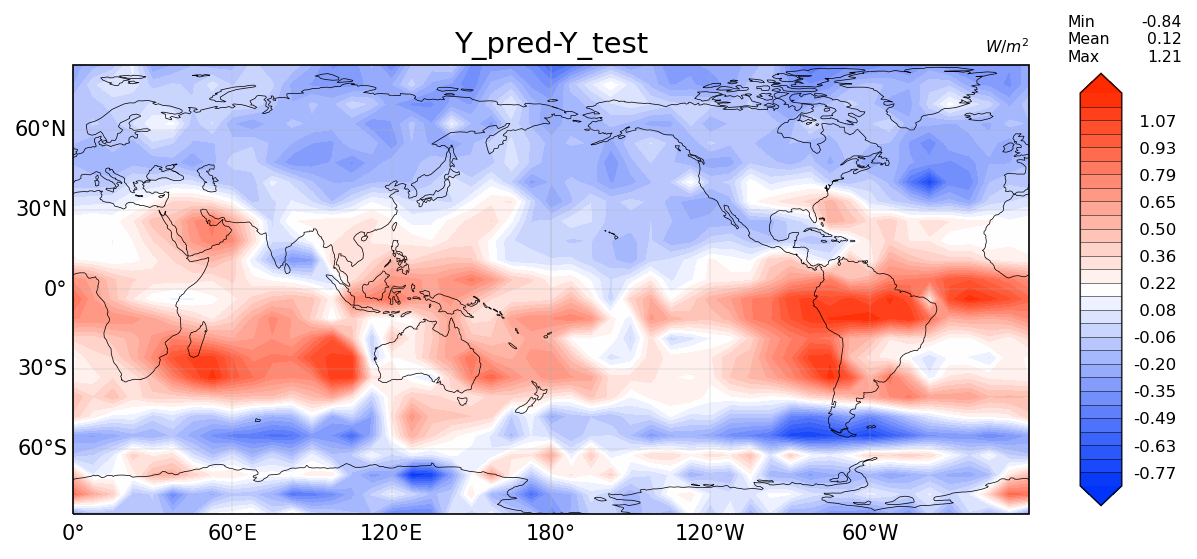

In [43]:
Y_plot=np.reshape(Y_obs,(24,48))
y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_actual",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_obs_xr)
sample_plot = cviz.contour.plot_lat_lon(
cmap_name="e3sm_default_diff",
title="Y_pred-Y_test",
rhs_title=r"$W/m^2$",
lhs_title="",
)
sample_plot.show((y_pred_xr-y_obs_xr))

In [44]:
np.mean(np.square(Y_obs-Y_obs_pred.squeeze()))

0.14835237

In [45]:
np.min(np.mean(np.square(Y_obs-Y), axis=(1,2)))

0.059853606

In [46]:
np.mean(np.square(Y_obs-Y[196].squeeze()))

0.059853606

In [47]:
Y_obs.shape

(24, 48)

## Custom Loss 2

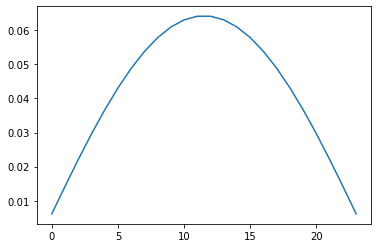

In [111]:
area_weight_arr/=sum(area_weight_arr)
plt.plot(area_weight_arr)
area_weight_arr=np.array(area_weight.mean(dim="lon").values,dtype='float32')

In [112]:
class DeConvNeuralNetwork2(BaseEstimator):
    def __init__(self,area_weight_arr,learning_rate=1e-4,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.model=None
        self.area_weight_arr=area_weight_arr
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred
#         z=kb.exp(-kb.abs(kb.arange(24,dtype=float)-11.5)/2+1e-15)
#         weights=z/kb.sum(z)
        weights=self.area_weight_arr/kb.sum(self.area_weight_arr)

        custom_loss=kb.mean(err**2* kb.reshape(weights,(1,-1,1)))**0.5
        #custom_loss=kb.square(y_actual-y_pred)
        return custom_loss
    def fit(self,X,y=None,**fit_params):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=5))
        model.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Reshape((3,3,1)))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3), strides=(1, 1), padding='same'))
        lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=1000,decay_rate=0.7)
        model.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=self.custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        history=model.fit(X,y,epochs=self.epochs)
        self.history=history
        self.model=model
        return model,history
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)
    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
            
    def evaluate(self,X,Y):
        return self.model.evaluate(X,Y)
    def plot_model(self,to_file='large_model_plot.png', show_shapes=True, show_layer_names=False):
        plot_model(self.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [113]:
Dnn2= DeConvNeuralNetwork2(area_weight_arr,epochs=2000)

In [114]:
Dnn2.fit(X_train,Y_train)

Epoch 1/2000
7/7 [==============================] - 2s 77ms/step - loss: 0.1943 - root_mean_squared_error: 1.0215
Epoch 2/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.1779 - root_mean_squared_error: 0.9500
Epoch 3/2000
7/7 [==============================] - 0s 27ms/step - loss: 0.1595 - root_mean_squared_error: 0.8568
Epoch 4/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.1367 - root_mean_squared_error: 0.7338
Epoch 5/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.1150 - root_mean_squared_error: 0.6182
Epoch 6/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0977 - root_mean_squared_error: 0.5315
Epoch 7/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0860 - root_mean_squared_error: 0.4611
Epoch 8/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0764 - root_mean_squared_error: 0.4041
Epoch 9/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0672 - root_m

Epoch 143/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0233 - root_mean_squared_error: 0.1094
Epoch 144/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0210 - root_mean_squared_error: 0.1003
Epoch 145/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0211 - root_mean_squared_error: 0.1006
Epoch 146/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0205 - root_mean_squared_error: 0.0980
Epoch 147/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0210 - root_mean_squared_error: 0.1002
Epoch 148/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0211 - root_mean_squared_error: 0.1006
Epoch 149/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0201 - root_mean_squared_error: 0.0964
Epoch 150/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0204 - root_mean_squared_error: 0.0974
Epoch 151/2000
7/7 [==============================] - 0s 22ms/step - los

7/7 [==============================] - 0s 22ms/step - loss: 0.0179 - root_mean_squared_error: 0.0860
Epoch 284/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0170 - root_mean_squared_error: 0.0822
Epoch 285/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0173 - root_mean_squared_error: 0.0833
Epoch 286/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0177 - root_mean_squared_error: 0.0847
Epoch 287/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0177 - root_mean_squared_error: 0.0848
Epoch 288/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0175 - root_mean_squared_error: 0.0840
Epoch 289/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0173 - root_mean_squared_error: 0.0830
Epoch 290/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0170 - root_mean_squared_error: 0.0823
Epoch 291/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0177 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0170 - root_mean_squared_error: 0.0814
Epoch 424/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0179 - root_mean_squared_error: 0.0846
Epoch 425/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0173 - root_mean_squared_error: 0.0826
Epoch 426/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0162 - root_mean_squared_error: 0.0784
Epoch 427/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0167 - root_mean_squared_error: 0.0804
Epoch 428/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0164 - root_mean_squared_error: 0.0788
Epoch 429/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0171 - root_mean_squared_error: 0.0824
Epoch 430/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0160 - root_mean_squared_error: 0.0773
Epoch 431/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0164 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.0726
Epoch 564/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.0727
Epoch 565/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0157 - root_mean_squared_error: 0.0753
Epoch 566/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0153 - root_mean_squared_error: 0.0739
Epoch 567/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0157 - root_mean_squared_error: 0.0756
Epoch 568/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0153 - root_mean_squared_error: 0.0740
Epoch 569/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0151 - root_mean_squared_error: 0.0735
Epoch 570/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0149 - root_mean_squared_error: 0.0726
Epoch 571/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0145 - root_mean_squared_error: 0.0709
Epoch 704/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - root_mean_squared_error: 0.0704
Epoch 705/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.0717
Epoch 706/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - root_mean_squared_error: 0.0704
Epoch 707/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.0717
Epoch 708/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.0720
Epoch 709/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0151 - root_mean_squared_error: 0.0729
Epoch 710/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.0715
Epoch 711/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0141 - root_mean_squared_error: 0.0691
Epoch 844/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0141 - root_mean_squared_error: 0.0690
Epoch 845/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0141 - root_mean_squared_error: 0.0688
Epoch 846/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0140 - root_mean_squared_error: 0.0686
Epoch 847/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0141 - root_mean_squared_error: 0.0691
Epoch 848/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.0723
Epoch 849/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.0722
Epoch 850/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0142 - root_mean_squared_error: 0.0694
Epoch 851/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.0677
Epoch 984/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0140 - root_mean_squared_error: 0.0682
Epoch 985/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0140 - root_mean_squared_error: 0.0685
Epoch 986/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.0672
Epoch 987/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0142 - root_mean_squared_error: 0.0688
Epoch 988/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.0678
Epoch 989/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.0673
Epoch 990/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0669
Epoch 991/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0134 - root_mean_squared_error: 0.0658
Epoch 1124/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0134 - root_mean_squared_error: 0.0661
Epoch 1125/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.0673
Epoch 1126/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0669
Epoch 1127/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0667
Epoch 1128/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0661
Epoch 1129/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0668
Epoch 1130/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.0678
Epoch 1131/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0658
Epoch 1264/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0132 - root_mean_squared_error: 0.0652
Epoch 1265/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0133 - root_mean_squared_error: 0.0655
Epoch 1266/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0135 - root_mean_squared_error: 0.0663
Epoch 1267/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0135 - root_mean_squared_error: 0.0661
Epoch 1268/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0660
Epoch 1269/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0133 - root_mean_squared_error: 0.0658
Epoch 1270/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0658
Epoch 1271/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 21ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1404/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0132 - root_mean_squared_error: 0.0651
Epoch 1405/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0133 - root_mean_squared_error: 0.0656
Epoch 1406/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0134 - root_mean_squared_error: 0.0660
Epoch 1407/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0136 - root_mean_squared_error: 0.0669
Epoch 1408/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0132 - root_mean_squared_error: 0.0648
Epoch 1409/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0132 - root_mean_squared_error: 0.0650
Epoch 1410/2000
7/7 [==============================] - 0s 20ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1411/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1544/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0647
Epoch 1545/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0135 - root_mean_squared_error: 0.0660
Epoch 1546/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0130 - root_mean_squared_error: 0.0644
Epoch 1547/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0132 - root_mean_squared_error: 0.0648
Epoch 1548/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0132 - root_mean_squared_error: 0.0649
Epoch 1549/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1550/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0133 - root_mean_squared_error: 0.0654
Epoch 1551/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1684/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1685/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1686/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0132 - root_mean_squared_error: 0.0650
Epoch 1687/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0131 - root_mean_squared_error: 0.0645
Epoch 1688/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0641
Epoch 1689/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1690/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1691/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0641
Epoch 1824/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0641
Epoch 1825/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0640
Epoch 1826/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1827/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1828/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1829/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1830/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0130 - root_mean_squared_error: 0.0640
Epoch 1831/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 21ms/step - loss: 0.0129 - root_mean_squared_error: 0.0636
Epoch 1964/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1965/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0634
Epoch 1966/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0635
Epoch 1967/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0131 - root_mean_squared_error: 0.0643
Epoch 1968/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0131 - root_mean_squared_error: 0.0645
Epoch 1969/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0128 - root_mean_squared_error: 0.0634
Epoch 1970/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0130 - root_mean_squared_error: 0.0641
Epoch 1971/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

(<keras.engine.sequential.Sequential at 0x303bb5b80>,
 <keras.callbacks.History at 0x30424ec70>)

In [116]:
Dnn2.evaluate(X_train,Y_train)

7/7 [==============================] - 1s 27ms/step - loss: 0.0126 - root_mean_squared_error: 0.0624


[0.012578227557241917, 0.062356214970350266]

In [117]:
Dnn2.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 120ms/step - loss: 0.0151 - root_mean_squared_error: 0.0711


[0.015063583850860596, 0.07106980681419373]

In [164]:
0.015063583850860596**2

0.00022691155843190813

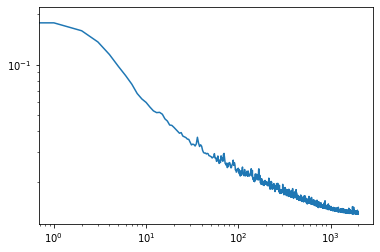

In [119]:
Dnn2.plot_loss()

In [120]:
Y_pred2=Dnn2.predict(X_test)

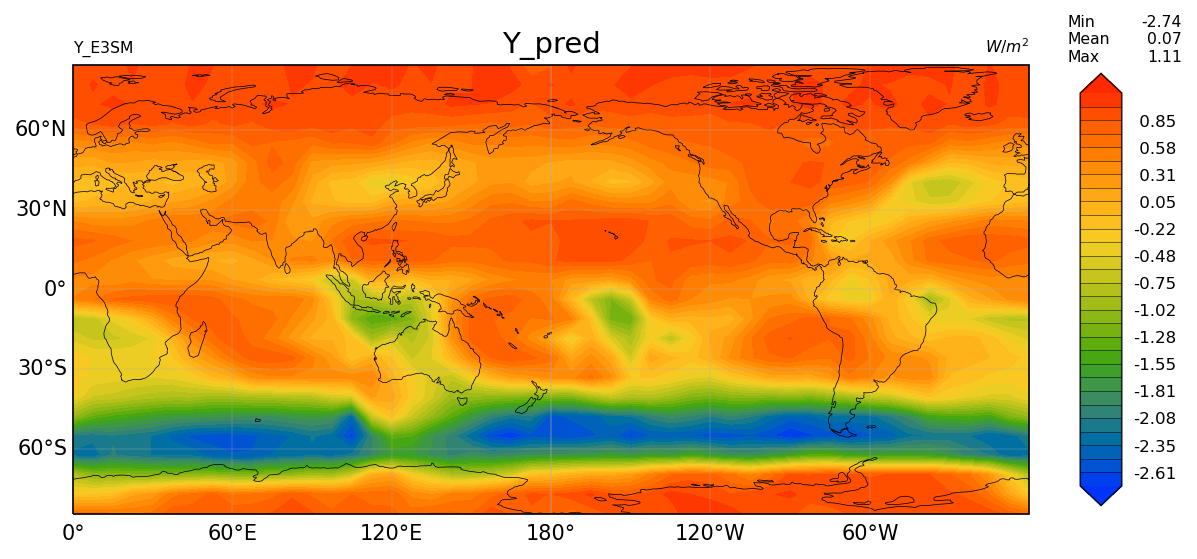

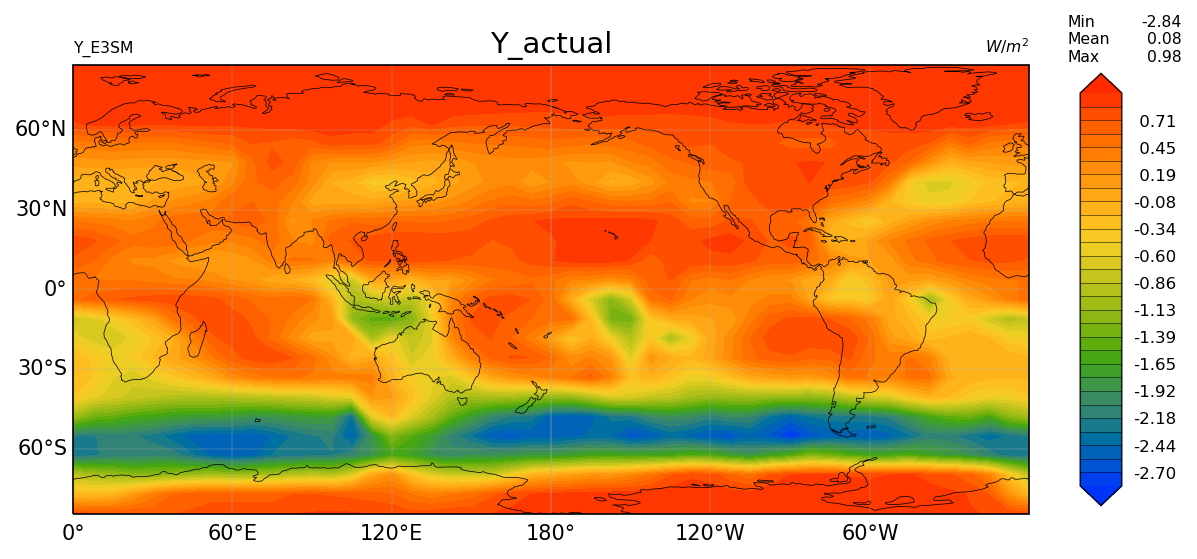

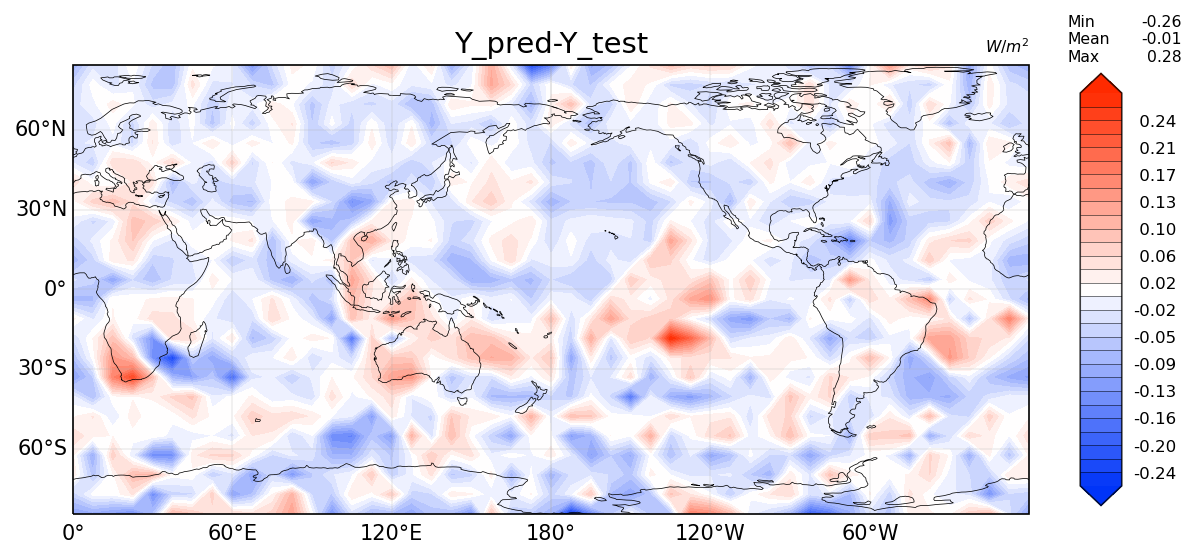

In [145]:
plot(Y_pred2,Y_test,-1)

## MSE

In [122]:
class DeConvNeuralNetwork_orig(BaseEstimator):
    def __init__(self,area_weight_arr,learning_rate=1e-4,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.model=None
        self.area_weight_arr=area_weight_arr
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred


        custom_loss=kb.square(y_actual-y_pred)
        return custom_loss
    def fit(self,X,y=None,**fit_params):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=5))
        model.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Reshape((3,3,1)))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3), strides=(1, 1), padding='same'))
        lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=1000,decay_rate=0.7)
        model.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=self.custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        history=model.fit(X,y,epochs=self.epochs)
        self.history=history
        self.model=model
        return model,history
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)
    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
            
    def evaluate(self,X,Y):
        return self.model.evaluate(X,Y)
    def plot_model(self,to_file='large_model_plot.png', show_shapes=True, show_layer_names=False):
        plot_model(self.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [236]:
Dnn3= DeConvNeuralNetwork_orig(area_weight_arr,epochs=10000)

In [237]:
Dnn3.fit(X_train,Y_train)

Epoch 1/10000
7/7 [==============================] - 3s 114ms/step - loss: 1.0399 - root_mean_squared_error: 1.0198
Epoch 2/10000
7/7 [==============================] - 0s 36ms/step - loss: 0.8812 - root_mean_squared_error: 0.9387
Epoch 3/10000
7/7 [==============================] - 0s 32ms/step - loss: 0.6896 - root_mean_squared_error: 0.8304
Epoch 4/10000
7/7 [==============================] - 0s 36ms/step - loss: 0.4930 - root_mean_squared_error: 0.7022
Epoch 5/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.3434 - root_mean_squared_error: 0.5860
Epoch 6/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.2428 - root_mean_squared_error: 0.4927
Epoch 7/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288
Epoch 8/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.1448 - root_mean_squared_error: 0.3806
Epoch 9/10000
7/7 [==============================] - 0s 27ms/step - loss: 0.119

7/7 [==============================] - 0s 21ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053
Epoch 142/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110
Epoch 143/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0113 - root_mean_squared_error: 0.1063
Epoch 144/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092
Epoch 145/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067
Epoch 146/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052
Epoch 147/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 148/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087
Epoch 149/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915
Epoch 282/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912
Epoch 283/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932
Epoch 284/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0079 - root_mean_squared_error: 0.0886
Epoch 285/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0076 - root_mean_squared_error: 0.0875
Epoch 286/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857
Epoch 287/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877
Epoch 288/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905
Epoch 289/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.00

7/7 [==============================] - 0s 21ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774
Epoch 422/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775
Epoch 423/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0060 - root_mean_squared_error: 0.0778
Epoch 424/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770
Epoch 425/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774
Epoch 426/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811
Epoch 427/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808
Epoch 428/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0062 - root_mean_squared_error: 0.0789
Epoch 429/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.00

7/7 [==============================] - 0s 21ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740
Epoch 562/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734
Epoch 563/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723
Epoch 564/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720
Epoch 565/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752
Epoch 566/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750
Epoch 567/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762
Epoch 568/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0054 - root_mean_squared_error: 0.0738
Epoch 569/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.00

7/7 [==============================] - 0s 25ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726
Epoch 702/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697
Epoch 703/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715
Epoch 704/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705
Epoch 705/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704
Epoch 706/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709
Epoch 707/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0048 - root_mean_squared_error: 0.0692
Epoch 708/10000
7/7 [==============================] - 0s 26ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694
Epoch 709/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.00

7/7 [==============================] - 0s 22ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691
Epoch 842/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698
Epoch 843/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701
Epoch 844/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0047 - root_mean_squared_error: 0.0682
Epoch 845/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694
Epoch 846/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694
Epoch 847/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693
Epoch 848/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691
Epoch 849/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.00

7/7 [==============================] - 0s 22ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660
Epoch 982/10000
7/7 [==============================] - 0s 26ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664
Epoch 983/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659
Epoch 984/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678
Epoch 985/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672
Epoch 986/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663
Epoch 987/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668
Epoch 988/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671
Epoch 989/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.00

7/7 [==============================] - 0s 22ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646
Epoch 1120/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651
Epoch 1121/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646
Epoch 1122/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647
Epoch 1123/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647
Epoch 1124/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658
Epoch 1125/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647
Epoch 1126/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663
Epoch 1127/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649
Epoch 1258/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649
Epoch 1259/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0041 - root_mean_squared_error: 0.0643
Epoch 1260/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647
Epoch 1261/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638
Epoch 1262/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638
Epoch 1263/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 1264/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0042 - root_mean_squared_error: 0.0645
Epoch 1265/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636
Epoch 1396/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646
Epoch 1397/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649
Epoch 1398/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642
Epoch 1399/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660
Epoch 1400/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636
Epoch 1401/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 1402/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 1403/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638
Epoch 1534/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632
Epoch 1535/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649
Epoch 1536/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 1537/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 1538/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 1539/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632
Epoch 1540/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637
Epoch 1541/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 1672/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 1673/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 1674/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632
Epoch 1675/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 1676/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 1677/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 1678/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 1679/10000
7/7 [==============================] - 0s 23ms/step - lo

7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 1810/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640
Epoch 1811/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 1812/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 1813/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 1814/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 1815/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 1816/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636
Epoch 1817/10000
7/7 [==============================] - 0s 23ms/step - lo

7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 1948/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 1949/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 1950/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 1951/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 1952/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 1953/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 1954/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 1955/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 2086/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 2087/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 2088/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 2089/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 2090/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 2091/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 2092/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0635
Epoch 2093/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 2224/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 2225/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 2226/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637
Epoch 2227/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 2228/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 2229/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 2230/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 2231/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 2362/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 2363/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 2364/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 2365/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 2366/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 2367/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 2368/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 2369/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 2500/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 2501/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 2502/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 2503/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 2504/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 2505/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 2506/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 2507/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 2638/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 2639/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 2640/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 2641/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 2642/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612
Epoch 2643/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 2644/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 2645/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 2776/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 2777/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 2778/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 2779/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 2780/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 2781/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 2782/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 2783/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 2914/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648
Epoch 2915/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 2916/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 2917/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 2918/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 2919/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 2920/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 2921/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 3052/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 3053/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 3054/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 3055/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 3056/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 3057/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 3058/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 3059/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 3190/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 3191/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 3192/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 3193/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 3194/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641
Epoch 3195/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 3196/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 3197/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 3328/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 3329/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 3330/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 3331/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 3332/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 3333/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 3334/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 3335/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 3466/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 3467/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 3468/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 3469/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 3470/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 3471/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 3472/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 3473/10000
7/7 [==============================] - 0s 23ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 3604/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 3605/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 3606/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 3607/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 3608/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 3609/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 3610/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 3611/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 3742/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651
Epoch 3743/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 3744/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 3745/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 3746/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 3747/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 3748/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 3749/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 3880/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 3881/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 3882/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 3883/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 3884/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 3885/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 3886/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 3887/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 4018/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 4019/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 4020/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 4021/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 4022/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 4023/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0620
Epoch 4024/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 4025/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 4156/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 4157/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 4158/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 4159/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 4160/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 4161/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 4162/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 4163/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 4294/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 4295/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 4296/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 4297/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 4298/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 4299/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 4300/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 4301/10000
7/7 [==============================] - 0s 20ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 4432/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632
Epoch 4433/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 4434/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 4435/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 4436/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 4437/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 4438/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 4439/10000
7/7 [==============================] - 0s 23ms/step - lo

7/7 [==============================] - 0s 25ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 4570/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 4571/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 4572/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0635
Epoch 4573/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 4574/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 4575/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 4576/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 4577/10000
7/7 [==============================] - 0s 24ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 4708/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 4709/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 4710/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 4711/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 4712/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 4713/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 4714/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 4715/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 4846/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 4847/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 4848/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 4849/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 4850/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 4851/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 4852/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 4853/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 4984/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 4985/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 4986/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 4987/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 4988/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 4989/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 4990/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 4991/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 5122/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 5123/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 5124/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 5125/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 5126/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 5127/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 5128/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 5129/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 5260/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 5261/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 5262/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 5263/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 5264/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 5265/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 5266/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 5267/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 5398/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 5399/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 5400/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 5401/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 5402/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 5403/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 5404/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 5405/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 5536/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 5537/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 5538/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 5539/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 5540/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 5541/10000
7/7 [==============================] - 0s 26ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 5542/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 5543/10000
7/7 [==============================] - 0s 23ms/step - lo

7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 5674/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0612
Epoch 5675/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 5676/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 5677/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 5678/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 5679/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 5680/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 5681/10000
7/7 [==============================] - 0s 23ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 5812/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 5813/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 5814/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 5815/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 5816/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 5817/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 5818/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 5819/10000
7/7 [==============================] - 0s 23ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 5950/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 5951/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636
Epoch 5952/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 5953/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 5954/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 5955/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 5956/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 5957/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 6088/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 6089/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 6090/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 6091/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 6092/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611
Epoch 6093/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 6094/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 6095/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 6226/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 6227/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 6228/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 6229/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 6230/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 6231/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 6232/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636
Epoch 6233/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 6364/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 6365/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 6366/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 6367/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 6368/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 6369/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 6370/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 6371/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 6502/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 6503/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 6504/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 6505/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 6506/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 6507/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647
Epoch 6508/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 6509/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 6640/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 6641/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 6642/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 6643/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 6644/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 6645/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 6646/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 6647/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 6778/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 6779/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 6780/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 6781/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 6782/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 6783/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 6784/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 6785/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 6916/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 6917/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632
Epoch 6918/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 6919/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 6920/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 6921/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 6922/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 6923/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 7054/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 7055/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 7056/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 7057/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 7058/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 7059/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 7060/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 7061/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 7192/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636
Epoch 7193/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 7194/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 7195/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 7196/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 7197/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 7198/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 7199/10000
7/7 [==============================] - 0s 23ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 7330/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 7331/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 7332/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 7333/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 7334/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 7335/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 7336/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640
Epoch 7337/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 7468/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 7469/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 7470/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 7471/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 7472/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 7473/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 7474/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612
Epoch 7475/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 7606/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 7607/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 7608/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 7609/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 7610/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 7611/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 7612/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641
Epoch 7613/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 7744/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 7745/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640
Epoch 7746/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 7747/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 7748/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 7749/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 7750/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 7751/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 7882/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 7883/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 7884/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 7885/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 7886/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 7887/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 7888/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 7889/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 8020/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 8021/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 8022/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 8023/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 8024/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 8025/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 8026/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 8027/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 23ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637
Epoch 8158/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 8159/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 8160/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 8161/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 8162/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 8163/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 8164/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 8165/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 8296/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 8297/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 8298/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 8299/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 8300/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 8301/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 8302/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 8303/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 8434/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 8435/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 8436/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 8437/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 8438/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 8439/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 8440/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 8441/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 8572/10000
7/7 [==============================] - 0s 23ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 8573/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 8574/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 8575/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 8576/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 8577/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 8578/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 8579/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 8710/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 8711/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 8712/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629
Epoch 8713/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 8714/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 8715/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 8716/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 8717/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639
Epoch 8848/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 8849/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 8850/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 8851/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 8852/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 8853/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 8854/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 8855/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 8986/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 8987/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 8988/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 8989/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 8990/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 8991/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 8992/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 8993/10000
7/7 [==============================] - 0s 20ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 9124/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 9125/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 9126/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622
Epoch 9127/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 9128/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 9129/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 9130/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 9131/10000
7/7 [==============================] - 0s 25ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 9262/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 9263/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 9264/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 9265/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 9266/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 9267/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 9268/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 9269/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 20ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 9400/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 9401/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 9402/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 9403/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626
Epoch 9404/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 9405/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 9406/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623
Epoch 9407/10000
7/7 [==============================] - 0s 22ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 9538/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 9539/10000
7/7 [==============================] - 0s 24ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 9540/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 9541/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 9542/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 9543/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 9544/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 9545/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 9676/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 9677/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 9678/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 9679/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 9680/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 9681/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 9682/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 9683/10000
7/7 [==============================] - 0s 21ms/step - lo

7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 9814/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621
Epoch 9815/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 9816/10000
7/7 [==============================] - 0s 20ms/step - loss: 0.0043 - root_mean_squared_error: 0.0652
Epoch 9817/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 9818/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 9819/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618
Epoch 9820/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 9821/10000
7/7 [==============================] - 0s 20ms/step - lo

7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 9952/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 9953/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 9954/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620
Epoch 9955/10000
7/7 [==============================] - 0s 25ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 9956/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 9957/10000
7/7 [==============================] - 0s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 9958/10000
7/7 [==============================] - 0s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617
Epoch 9959/10000
7/7 [==============================] - 0s 21ms/step - lo

(<keras.engine.sequential.Sequential at 0x3c4c59af0>,
 <keras.callbacks.History at 0x3c618b6d0>)

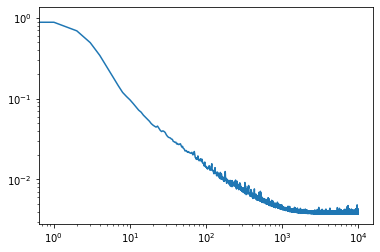

In [241]:
Dnn3.plot_loss()

In [242]:
Y_pred3=Dnn3.predict(X_test)

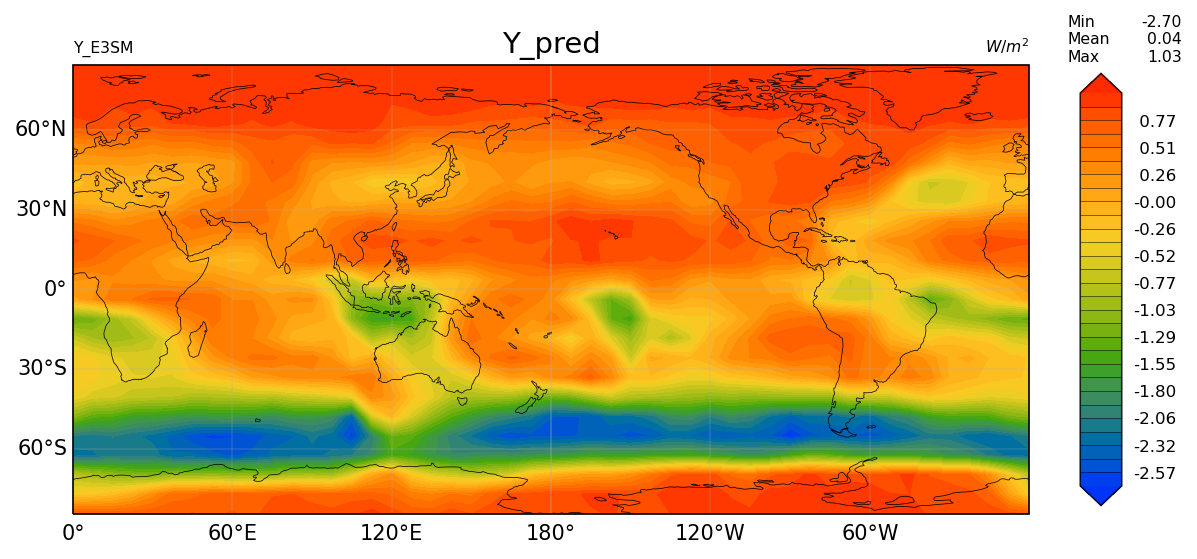

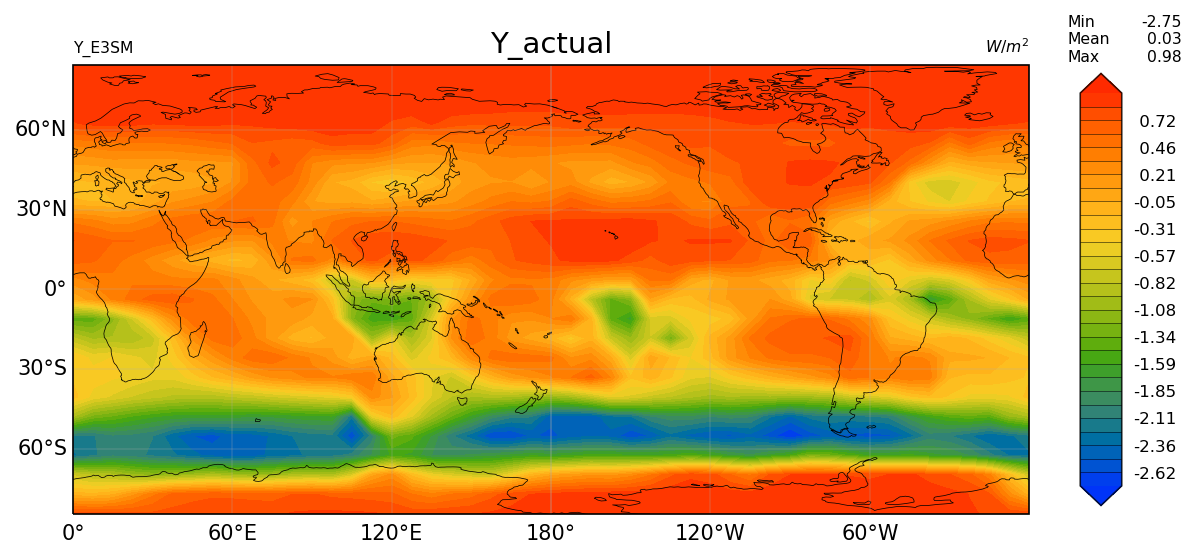

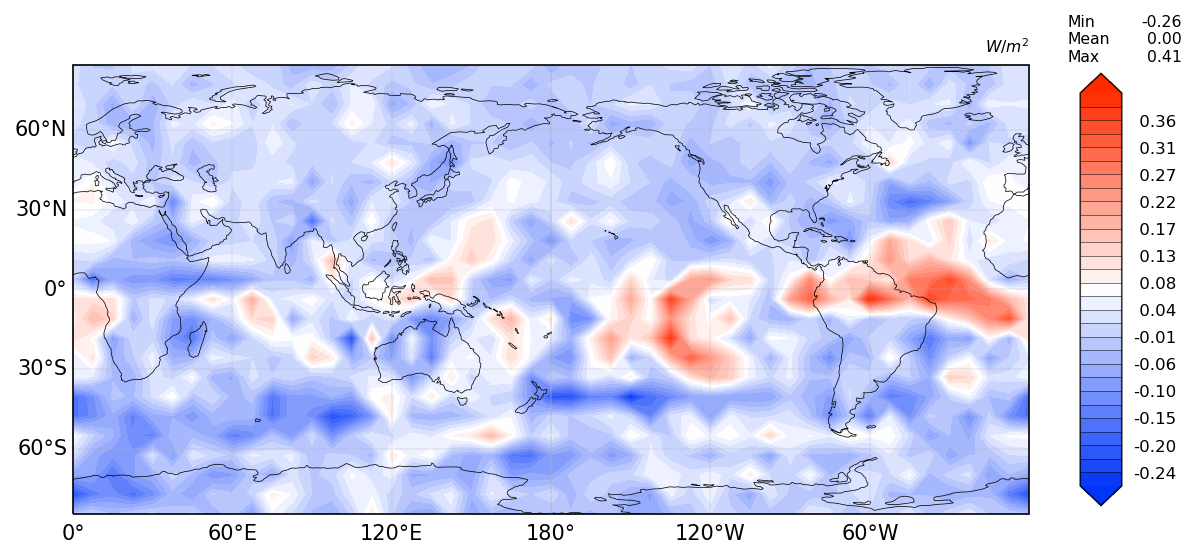

In [247]:
plot(Y_pred3,Y_test,-3)

In [248]:
Dnn3.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 22ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681


[0.004632256459444761, 0.06806068867444992]